In [1]:
import numpy as np
import scipy as sp
import scipy.io
from scipy.stats import unitary_group
from datetime import datetime
import matplotlib.pyplot as plt
import qutip as qt
#from scipy.optimize import curve_fit
import os
import uuid
from itertools import repeat, chain, product, combinations
from joblib import Parallel, delayed
import glob
import time
from EMQST_lib import support_functions as sf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM
from EMQST_lib import dt
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
from EMQST_lib import photon as ph
from functools import reduce
from cvxopt import matrix, solvers
%load_ext autoreload
%autoreload 2

### Loading in data from .mat and .txt file

In [2]:
# Loading in the QST calibration states data.

is_math_file = False
if is_math_file:
    
    path  = "Photon_REM/photonic QREM experimental data v2/calibration states/*"
    paths = glob.glob(path)
    print(paths)
    mat_files = [glob.glob(p + "/*.mat")[0] for p in paths]

    # Load from math files
    QST_coinc_count_dic = [sp.io.loadmat(f) for f in mat_files]
    QST_keys = [list(mat.keys())[3] for mat in QST_coinc_count_dic]

    QST_coinc_counts = [mat[key] for mat, key in zip(QST_coinc_count_dic, QST_keys)]
    
    # Load reconstructed density matrices
    qst_path = "Photon_REM/photonic QREM experimental data v2/calibration states/hvvh/hvvh_rho.mat"
    calib_rho_dict = sp.io.loadmat(qst_path) 
    calib_rho = calib_rho_dict['hvvh_rho']


    # Load the QDT coincidence counts
    qdt_path = "Photon_REM/photonic QREM experimental data v2/detector tomography/detTomo_coinc.mat"
    qdt_conc_dict = sp.io.loadmat(qdt_path)
    QDT_conts = qdt_conc_dict['detTomo_coinc'].T

else: # Is .txt
    path  = "Photon_REM/photonic QREM experimental data v2/calibration states/*coinc.txt"
    paths = glob.glob(path)
    print(paths)
    QST_coinc_counts = np.array([np.loadtxt(p, skiprows=2) for p in paths])[::-1]
    print(QST_coinc_counts)

    # Load reconstructed density matrices
    qst_path = glob.glob("Photon_REM/photonic QREM experimental data v2/calibration states/*rho.txt")
    # Read the file content
    with open(qst_path[0], 'r') as file:
        lines = file.readlines()
    #print(lines)
    # Initialize a list to store the complex matrix
    complex_matrix = []

    # Parse each line
    for line in lines:
        if line.strip() and '=' not in line:  # Ignore empty lines and the definition line
            # Replace i with j to make it compatible with Python's complex numbers
            formatted_line = line.replace('i', 'j').strip()
            # Split the line by spaces to extract each complex number
            row = [complex(num) for num in formatted_line.split()]
            complex_matrix.append(row)
            
    # Convert the list to a NumPy array
    calib_rho = np.array(complex_matrix)
    # Detector tomography coincidence counts
    qdt_path = "Photon_REM/photonic QREM experimental data v2/detector tomography/detTomo_coinc.txt"
    QDT_conts = np.loadtxt(qdt_path, skiprows=2)
    print(QDT_conts)

['Photon_REM/photonic QREM experimental data v2/calibration states\\hdva_coinc.txt', 'Photon_REM/photonic QREM experimental data v2/calibration states\\hrvl_coinc.txt', 'Photon_REM/photonic QREM experimental data v2/calibration states\\hvvh_coinc.txt']
[[  466. 21814.   285. 25819. 14858.  9516. 11640. 13613. 12792. 21949.
   9077.  8992. 12356. 11571. 10856.   854.]
 [10958. 12368.  9515. 10890.  7397. 13511.   796. 21845. 11949. 12916.
  19212. 14981.  6206.   293. 21613.  8407.]
 [ 5490. 17567.  4238. 18085. 17454.  4941.  3464. 21440. 11223. 18149.
   4619. 13455.  7315. 19300.  2183.  4749.]]
[  201. 12256.  5298.  3492.  7957.   233.  3902.  5253.  4361.  5083.
   164.  6145.  1598.  8417. 10223.  5570.  4895.  4330.  6694.  3271.
  6747.  2216.  1144.  3707.]


### Reconstructing the calibration states from coincidences 

Ideal state


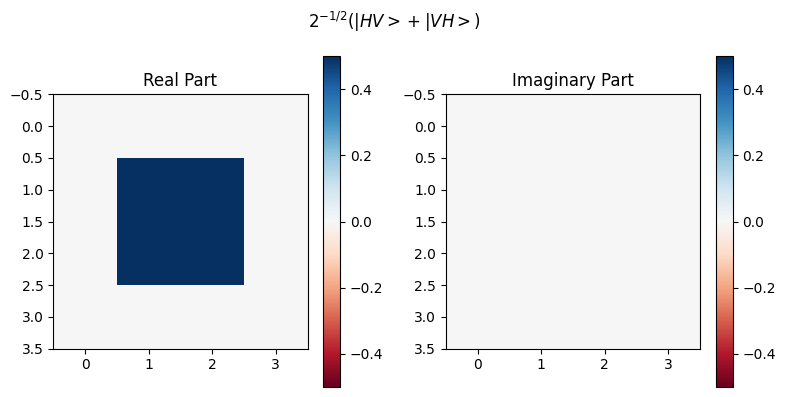

Ideal state


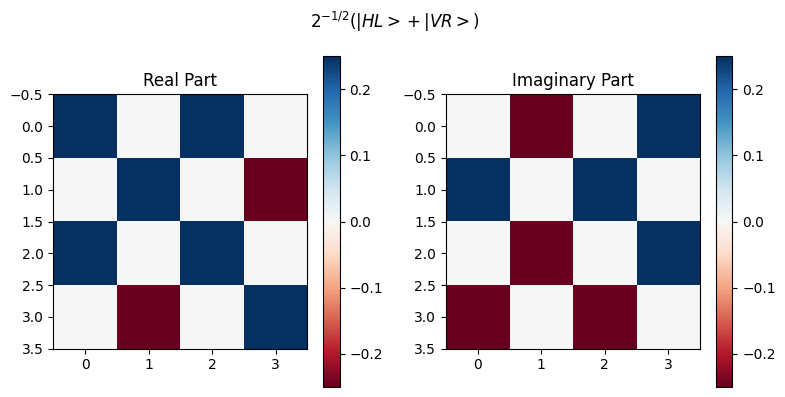

Ideal state


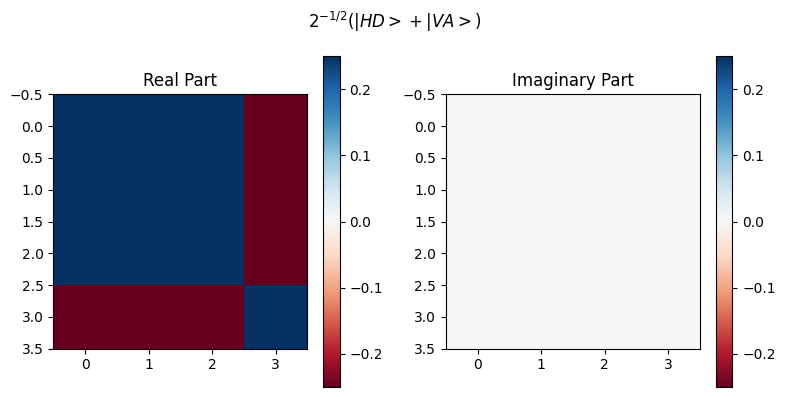

[[[ 0.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j  ]
  [ 0.  +0.j    0.5 +0.j    0.5 +0.j    0.  +0.j  ]
  [ 0.  +0.j    0.5 +0.j    0.5 +0.j    0.  +0.j  ]
  [ 0.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j  ]]

 [[ 0.25+0.j    0.  -0.25j  0.25+0.j    0.  +0.25j]
  [ 0.  +0.25j  0.25+0.j    0.  +0.25j -0.25+0.j  ]
  [ 0.25+0.j    0.  -0.25j  0.25+0.j    0.  +0.25j]
  [ 0.  -0.25j -0.25-0.j    0.  -0.25j  0.25+0.j  ]]

 [[ 0.25+0.j    0.25+0.j    0.25+0.j   -0.25-0.j  ]
  [ 0.25+0.j    0.25+0.j    0.25+0.j   -0.25-0.j  ]
  [ 0.25+0.j    0.25+0.j    0.25+0.j   -0.25-0.j  ]
  [-0.25+0.j   -0.25+0.j   -0.25+0.j    0.25+0.j  ]]]
[[  0. 500.   0. 500. 250. 250. 250. 250. 250. 500. 250. 250. 250. 250.
  250.   0.]
 [250. 250. 250. 250. 250. 250.   0. 500. 250. 250. 500. 250. 250.   0.
  500. 250.]
 [250. 250. 250. 250. 250. 250.   0. 500. 250. 250. 250. 500.   0. 250.
  250.   0.]]
{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Tue Nov 26 11:34:41 2024', '__version__': '1.0', '_

In [ ]:
# Define the eigenstates
plus_x = np.array([1, 1]) / np.sqrt(2)
minus_x = np.array([1, -1]) / np.sqrt(2)

plus_y = np.array([1, 1j]) / np.sqrt(2)
minus_y = np.array([1, -1j]) / np.sqrt(2)

plus_z = np.array([1, 0])
minus_z = np.array([0, 1])

# Define density matrices
xup = np.outer(plus_x, np.conj(plus_x))
xdown = np.outer(minus_x, np.conj(minus_x))

yup = np.outer(plus_y, np.conj(plus_y))
ydown = np.outer(minus_y, np.conj(minus_y))

zup = np.outer(plus_z, np.conj(plus_z))
zdown = np.outer(minus_z, np.conj(minus_z))

# Create the ideal calibration states
# [HD + VA, HR + VL, HV + VH]
ideal_calib_states = 1/np.sqrt(2) * np.array([np.kron(plus_z,minus_z) + np.kron(minus_z,plus_z),
                                              np.kron(plus_z,plus_y) + np.kron(minus_z,minus_y),
                                              np.kron(plus_z,plus_x) + np.kron(minus_z,minus_x)
                                              ])
ideal_calib_rho = np.array([np.outer(state,np.conj(state)) for state in ideal_calib_states])

# Create operator count order 
coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
                        'RH', 'RV', 'DV', 'DH',
                        'DR', 'DD', 'RD', 'HD',
                        'VD', 'VL', 'HL', 'RL']


QST_op_order = ph.photon_label_to_operator(coincidene_order_QST)

title_lables = np.array([r'$2^{-1/2}(|HV>+|VH>)$',r'$2^{-1/2}(|HL>+|VR>)$', r'$2^{-1/2}(|HD>+|VA>)$'])
# Reconstruct the 2 qubit calibration states
rho_list = [ph.coincidence_to_states(mat, QST_op_order) for mat in QST_coinc_counts]
# # Compare to the ideal ones.
for rho, rho_ideal, title in zip(rho_list,ideal_calib_rho, title_lables):
    #print('Exp reconstruction')
    #vis.visualize_state(rho)
    print('Ideal state')
    vis.visualize_state(rho_ideal, title = title )
#vis.visualize_state(calib_rho)
    
    
N_shots = 1000
print(ideal_calib_rho)
outcomes = ph.simulate_photon_coincidence_counts(N_shots, ideal_calib_rho, QST_op_order)
print(outcomes)

matrix_dict = {"HVVH": ideal_calib_rho[0], 
               "HLVR": ideal_calib_rho[1], 
               "HDVA": ideal_calib_rho[2]}
coinc_dict = {"order": coincidene_order_QST,
              "Total_orhtogonal_coinc": N_shots,
              "HVVH_coinc": outcomes[0],
              "HLVR_coinc": outcomes[1],
              "HDVA_coinc": outcomes[2]}

scipy.io.savemat('Photon_REM/deal_calibration_matrices.mat', matrix_dict)
scipy.io.savemat('Photon_REM/ideal_calibration_coinc.mat', coinc_dict)
test = sp.io.loadmat('Photon_REM/ideal_calibration_matrices.mat') 
test_2 = sp.io.loadmat('Photon_REM/ideal_calibration_coinc.mat')


Create the calibration states in two ways
1) From the 2 qubit reconstructions project onto ideal A channel projector and trace donw
2) Postselect 1 qubit data from the 2 qubit qst and reconstuct only B channel state

In [9]:
# Trace out herald states. 
# To do this we need to first know which states was measured by the Harald.
# 1) Project ideal harald projector on the reconstructed state.  
# 2) Trace out the harald qubit, givng the calibration state. 

# Creating the protocol calibration states
state_index_list = [0,0,1,2,1,2]
herald_projector_lables = ['H','V','H', 'H', 'V', 'V']
projector_list = ph.photon_label_to_operator(herald_projector_lables)
reshaped_states = np.array(rho_list).reshape(3,2,2,2,2)

# Apply projectors to the calibration states
projected_rho_list = np.array( [np.einsum('ij,jk,kl->il' , np.kron(proj,np.eye(2)), rho_list[rho_index], np.kron(proj,np.eye(2)) ) for rho_index, proj in zip(state_index_list, projector_list)])
# Renormalize the states
normalized_projected_rho_list = np.array([rho/np.trace(rho) for rho in projected_rho_list])
# Trace down
reshaped_states = normalized_projected_rho_list.reshape(6,2,2,2,2)
traced_down_calib_states = np.einsum('nijik -> njk', reshaped_states)
# for state in traced_down_calib_states:
#     vis.visualize_state(state)
#     print(np.trace(state))
#     print(np.trace(state@state))

# Directly reconstruct one qubit states.
# Select the proper samples # order HVDL
sample_index = np.array([[0,1,11,14],
                         [3,2,12,13]])
one_qubit_labels = ['H','V','D','L']	
one_qubit_projectors = ph.photon_label_to_operator(one_qubit_labels)
one_qubit_states = np.array([ph.coincidence_to_states(QST_coinc_counts[i,index],one_qubit_projectors,1) for i in range(len(QST_coinc_counts)) for index in sample_index ])
# Reoderd to match protocol calibration states
one_qubit_states = one_qubit_states[[0,1,2,4,3,5]]
print("Compare the two calibration states")
one_qubit_state_labels = ['H','V','L','D', 'R', "A"]
for i in range(len(one_qubit_states)):
    # vis.visualize_state(one_qubit_states[i])
    # vis.visualize_state(traced_down_calib_states[i])
    print(f'Difference between 1) and 2) for {one_qubit_state_labels[i]}: {sf.qubit_infidelity(one_qubit_states[i],traced_down_calib_states[i])}')

Compare the two calibration states
Difference between 1) and 2) for H: 0.0010886918524650735
Difference between 1) and 2) for V: 0.003227784698221381
Difference between 1) and 2) for L: 0.0034351338698177525
Difference between 1) and 2) for D: 0.010105059250834159
Difference between 1) and 2) for R: 0.0020357013779717104
Difference between 1) and 2) for A: 0.02135440855122528


### QDT reconstruct the POVM with lense 

In [10]:


exp_povm = ph.coincidence_to_POVM(QDT_conts.reshape((6,4)), traced_down_calib_states)

true_op_order_list = [['H','V'], ['L','R'],[ 'D','A']]
true_POVMs = np.array([ph.photon_label_to_operator(true_op_order) for true_op_order in true_op_order_list])
dist = [sf.POVM_distance(povm.get_POVM(), true_povm) for povm, true_povm in zip(exp_povm,true_POVMs)]
print(f'Distance between true and expected povm {dist}')

for i in range(len(exp_povm)):
    povm = exp_povm[i].get_POVM()
    true = true_POVMs[i]
    # vis.visualize_state(povm[0])
    # vis.visualize_state(true[0])
    # vis.visualize_state(povm[1])
    # vis.visualize_state(true[1])
#print(exp_povm[0].get_POVM())

	Number of MLE iterations: 50, final distance 1.7274237595898967e-12
	Number of MLE iterations: 100, final distance 6.5780714209040525e-15
	Number of MLE iterations: 950, final distance 4.5426951089666545e-10
Distance between true and expected povm [0.04416202993539567, 0.30560090692458725, 0.2450006399545663]


After having reconstructed the POVM, we want to implement it into the effective experiment.

[[ 9079. 12012.  7916. 11398.   576. 19536. 11110.  8965. 10047. 19125.
   8243.  9273.  9928.   139. 20324.  8689.]
 [ 2981.  4039.  3181.  3802.  1070.  6002.  5623.  1678.  2959.  5898.
   1406.  2847.  3534.    73.  9113.  4126.]]
Comparing accuracy between no lense and standard lense: 0.08823279641329884
Comparing accuracy between no lense and QREM lense: 0.09145000039739781


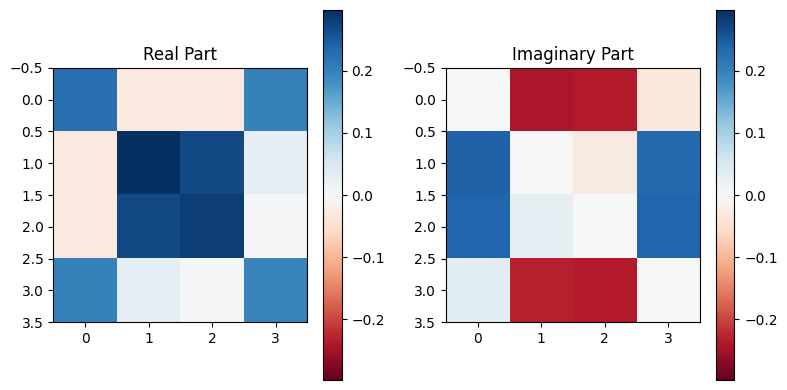

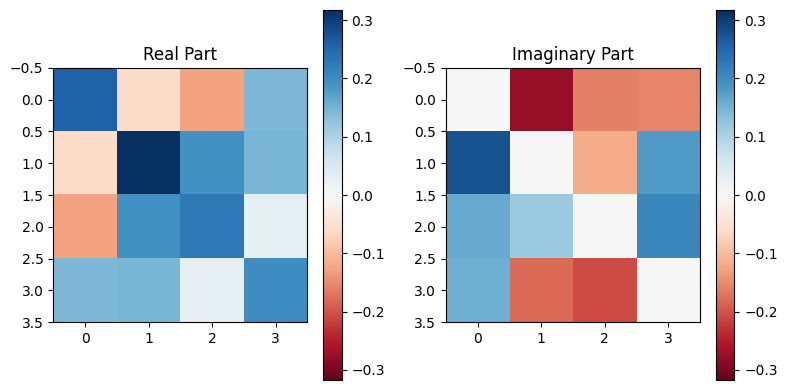

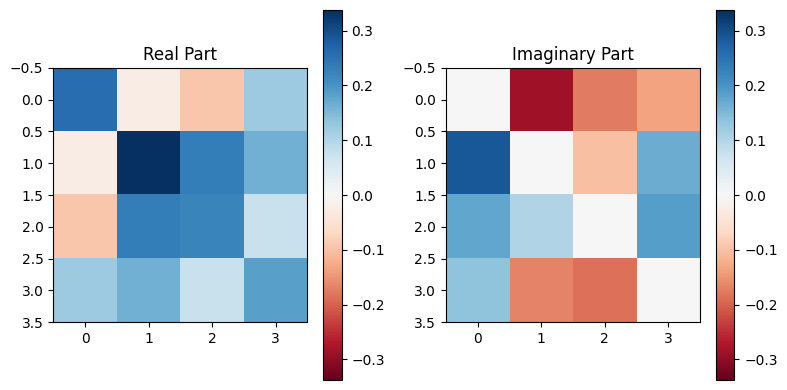

1

In [11]:
path  = "Photon_REM/photonic QREM experimental data v2/benchmark QREM/*coinc.txt"
paths = glob.glob(path)
benchmark_coinc_counts = np.array([np.loadtxt(p, skiprows=2) for p in paths])
print(benchmark_coinc_counts)

# Createing the error mitigated operator list

coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
                        'RH', 'RV', 'DV', 'DH',
                        'DR', 'DD', 'RD', 'HD',
                        'VD', 'VL', 'HL', 'RL']

# First operators is perfect, second will be taken from reconstruction. 
#[[H,V],[R,L],[D,A]] 
QREM_op_dict = {
    'H': exp_povm[0].get_POVM()[0],
    'V': exp_povm[0].get_POVM()[1],
    'L': exp_povm[1].get_POVM()[0],
    'R': exp_povm[1].get_POVM()[1],
    'D': exp_povm[2].get_POVM()[0],
    'A': exp_povm[2].get_POVM()[1]	
}
# Create the operator list for 2 qubit QREM
coincidence_op_list = np.array([np.kron(ph.photon_label_to_operator(name[0])[0], QREM_op_dict[name[1]]) for name in coincidene_order_QST])


QREM_rho = ph.coincidence_to_states(benchmark_coinc_counts[1], coincidence_op_list)

benchmark_rho_nolense = ph.coincidence_to_states(benchmark_coinc_counts[0], QST_op_order)
benchmark_rho_lense = ph.coincidence_to_states(benchmark_coinc_counts[1], QST_op_order)


print(f'Comparing accuracy between no lense and standard lense: {sf.qubit_infidelity(benchmark_rho_nolense, benchmark_rho_lense)}')
print(f'Comparing accuracy between no lense and QREM lense: {sf.qubit_infidelity(benchmark_rho_nolense, QREM_rho)}')
vis.visualize_state(benchmark_rho_nolense)
vis.visualize_state(benchmark_rho_lense)
vis.visualize_state(QREM_rho)
#vis.visualize_state(benchmark_rho_nolense - QREM_rho)


### Simulate photon QREM 

In [12]:

n_QDT_shots = 10**3
n_QST_shots = 10**3
projector_labels = ['H','V','R','D']
projectors = ph.photon_label_to_operator(projector_labels)
# Apply strong depolarizing noise
povm_projectors = POVM(projectors)
depol_POVM = POVM.depolarized_POVM(povm_projectors)
dephasing_POVM = POVM.generate_noisy_POVM(povm_projectors,4)
damped_POVM = POVM.generate_noisy_POVM(povm_projectors,3)


active_POVM = damped_POVM




# Simulate POVM measurements
sim_coincidence = ph.simulate_photon_coincidence_counts(n_QDT_shots, one_qubit_states, active_POVM.get_POVM())
sim_povm_recon = ph.coincidence_to_POVM(sim_coincidence, one_qubit_states)

# Simulate QST measurements
sim_rho_true = sf.generate_random_Hilbert_Schmidt_mixed_state(1)
QST_sim_coinc = ph.simulate_photon_coincidence_counts(n_QST_shots, [sim_rho_true], active_POVM.get_POVM())


QREM_op_dict = {
    'H': sim_povm_recon[0].get_POVM()[0],
    'V': sim_povm_recon[0].get_POVM()[1],
    'L': sim_povm_recon[1].get_POVM()[0],
    'R': sim_povm_recon[1].get_POVM()[1],
    'D': sim_povm_recon[2].get_POVM()[0],
    'A': sim_povm_recon[2].get_POVM()[1]	
}
sim_op_recon_list = np.array([QREM_op_dict[label] for label in projector_labels])

print(f'POVM recon accuracy: {sf.POVM_distance(sim_op_recon_list, active_POVM.get_POVM())}')

sim_rho_recon = ph.coincidence_to_states(QST_sim_coinc, sim_op_recon_list, n_qubits=1)

print(f'Simulated reconstruction accuracy: {sf.qubit_infidelity(sim_rho_recon, sim_rho_true)}')


	Number of MLE iterations: 300, final distance 1.6755133391832544e-10
	Number of MLE iterations: 150, final distance 3.6032288264209456e-13
	Number of MLE iterations: 700, final distance 3.4045517793845903e-10
POVM recon accuracy: 0.001411015427134267
Simulated reconstruction accuracy: 6.852644858224011e-07


Highlight issues:

Benchmark data ratio no lense/lense: [3.04562227 2.97400347 2.48852562 2.99789584 0.53831776 3.25491503
 1.97581362 5.34266985 3.39540385 3.24262462 5.86273115 3.25711275
 2.80928127 1.90410959 2.23022056 2.10591372]
Benchmark coincs: 
[[ 9079. 12012.  7916. 11398.   576. 19536. 11110.  8965. 10047. 19125.
   8243.  9273.  9928.   139. 20324.  8689.]
 [ 2981.  4039.  3181.  3802.  1070.  6002.  5623.  1678.  2959.  5898.
   1406.  2847.  3534.    73.  9113.  4126.]]
Problematic measurement is RH.
QDT coincs: 
[  201. 12256.  5298.  3492.  7957.   233.  3902.  5253.  4361.  5083.
   164.  6145.  1598.  8417. 10223.  5570.  4895.  4330.  6694.  3271.
  6747.  2216.  1144.  3707.]
Problematic is D state with R meaurement: 10223.0
and L state with R measurement: 6694.0
0.5160602124932168 0.5947964923728037
0.5160602124932168 0.5764432081434694
0.5160602124932168 0.4105599031643852
0.45192638853914224 0.5947964923728037
0.45192638853914224 0.5764432081434694
0.45192638853914224 0.4105599031

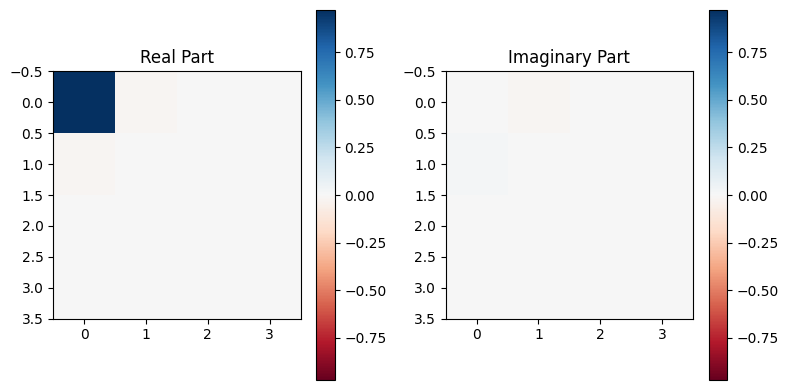

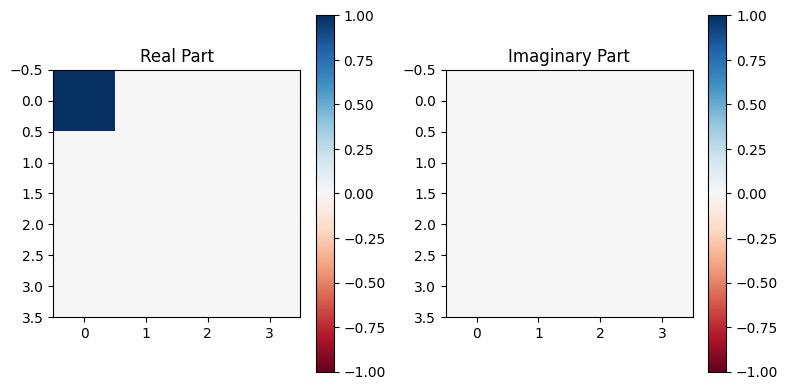

Opeators for HV


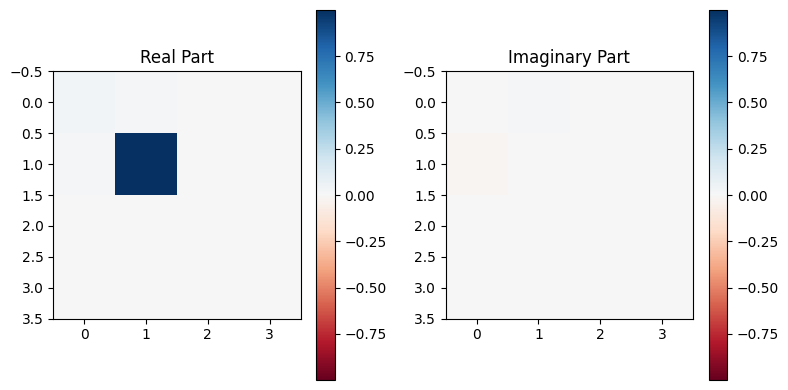

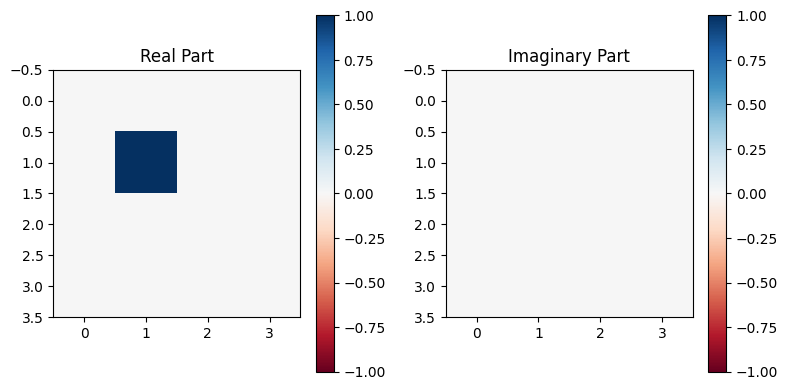

Opeators for VV


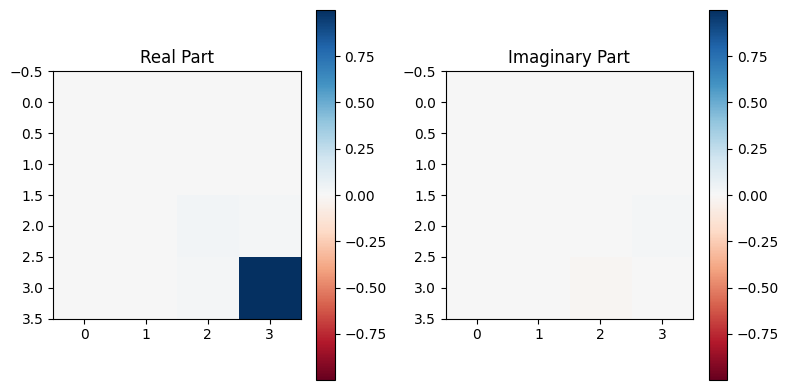

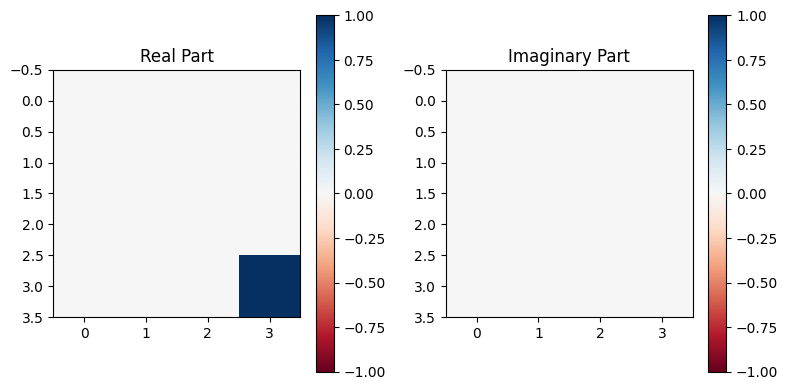

Opeators for VH


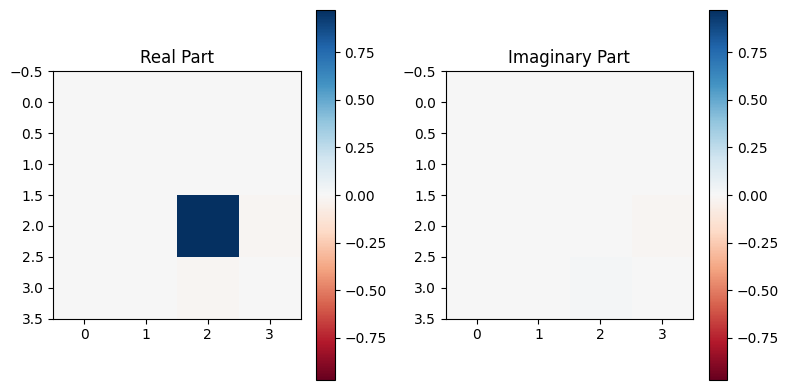

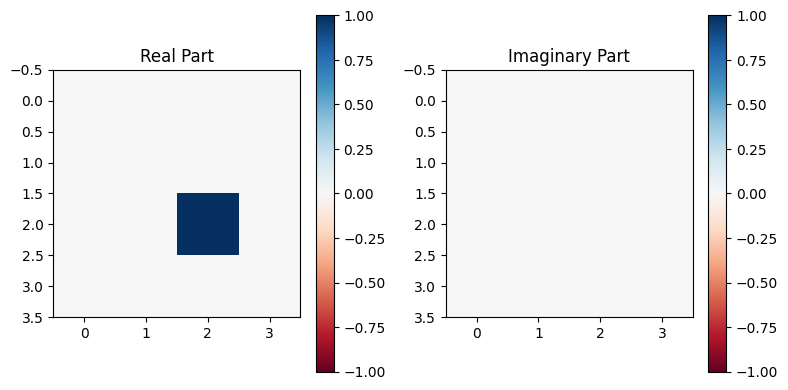

Opeators for RH


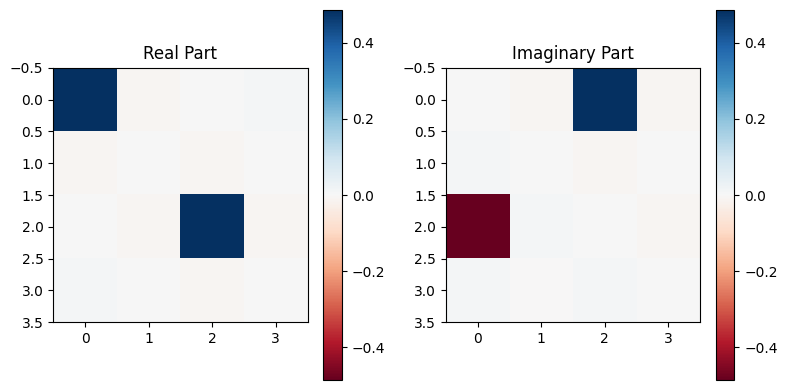

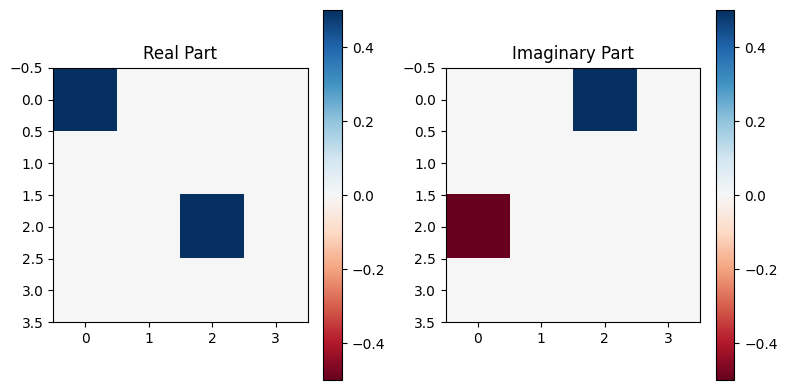

Opeators for RV


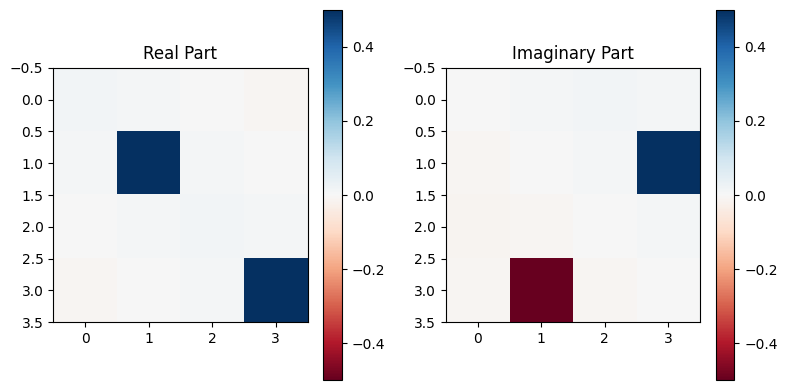

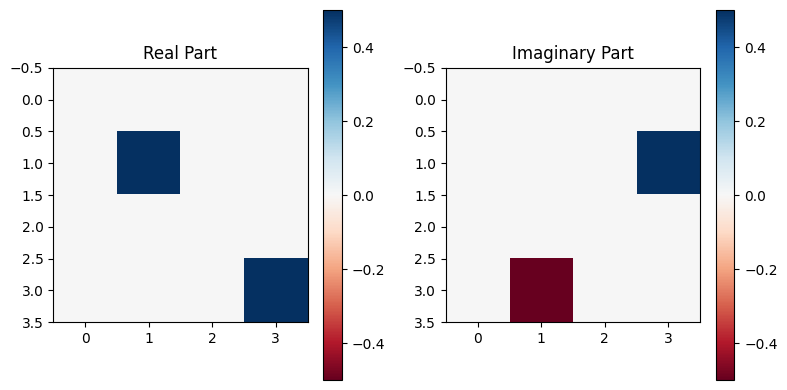

Opeators for DV


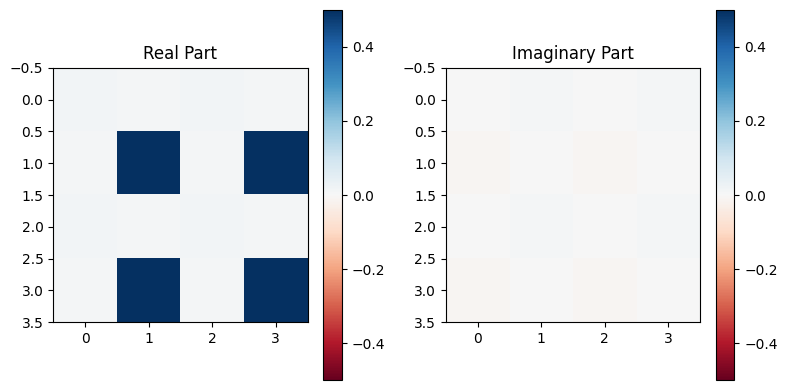

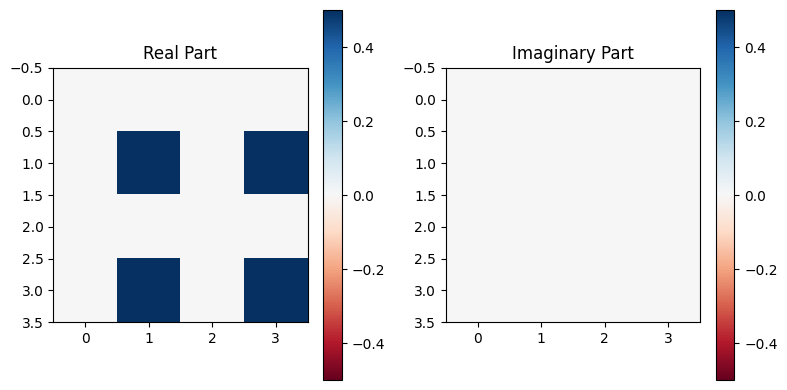

Opeators for DH


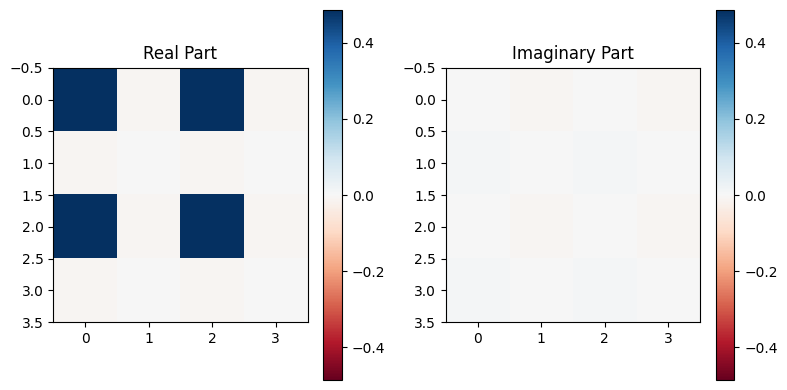

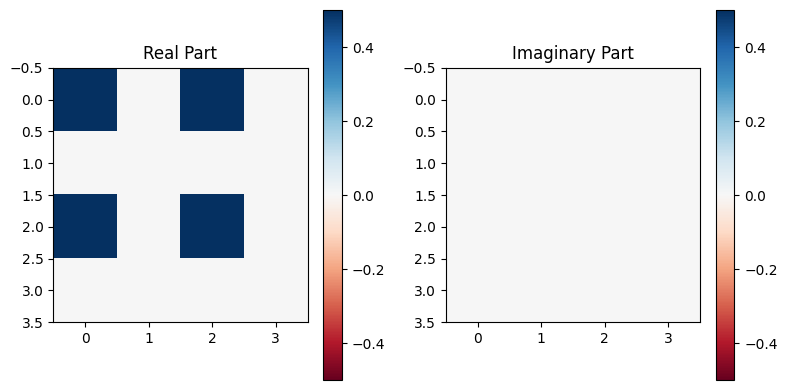

Opeators for DR


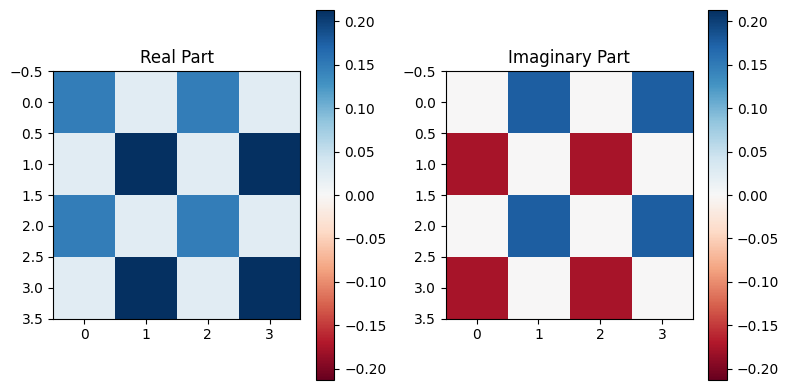

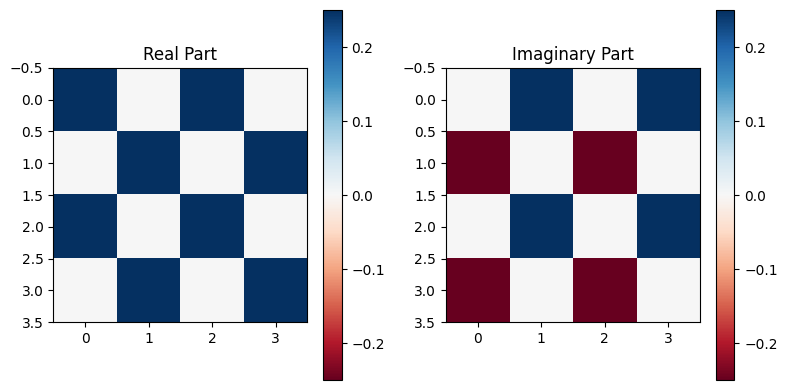

Opeators for DD


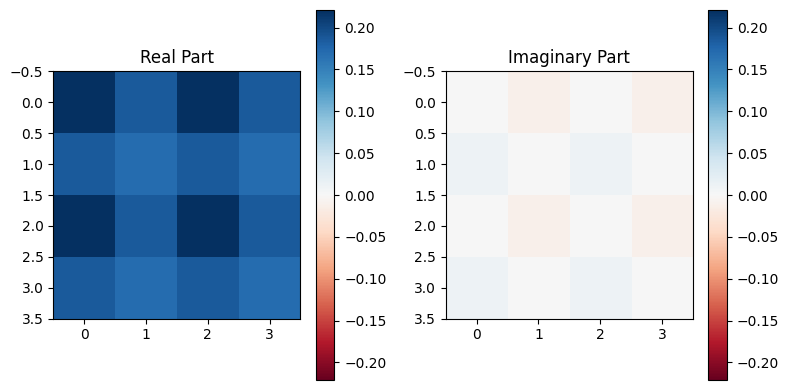

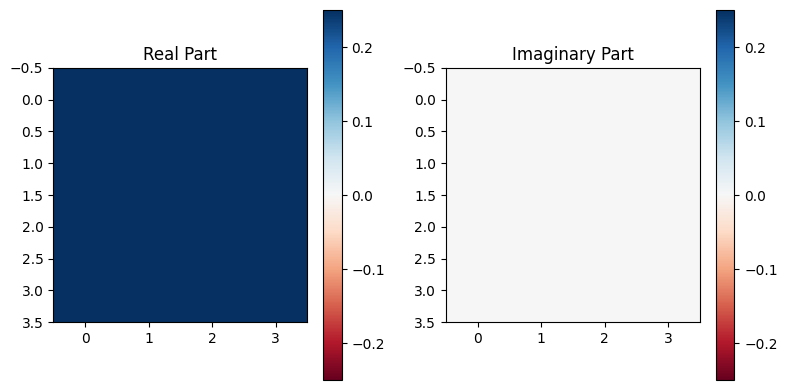

Opeators for RD


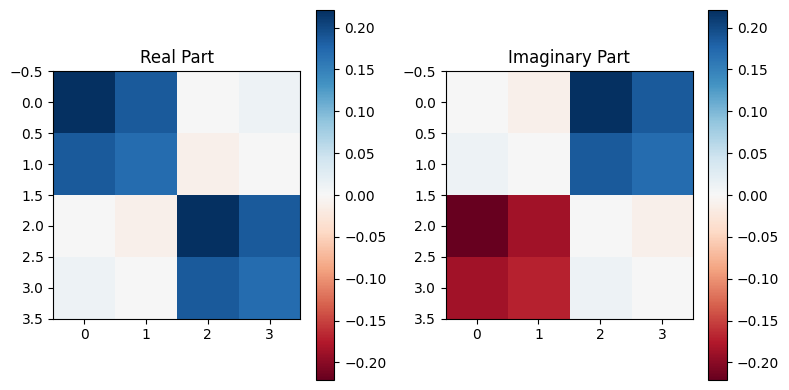

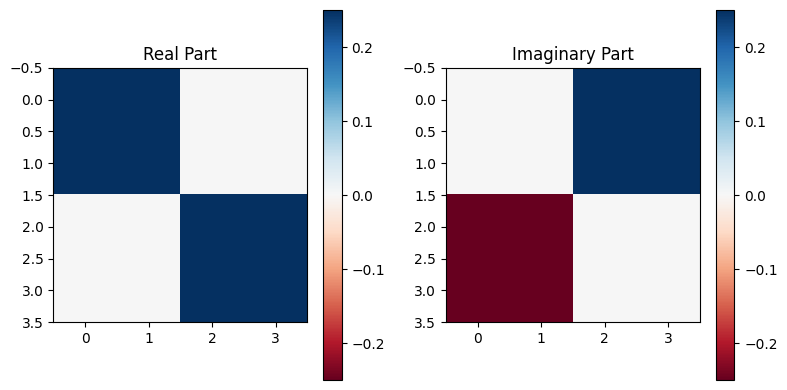

Opeators for HD


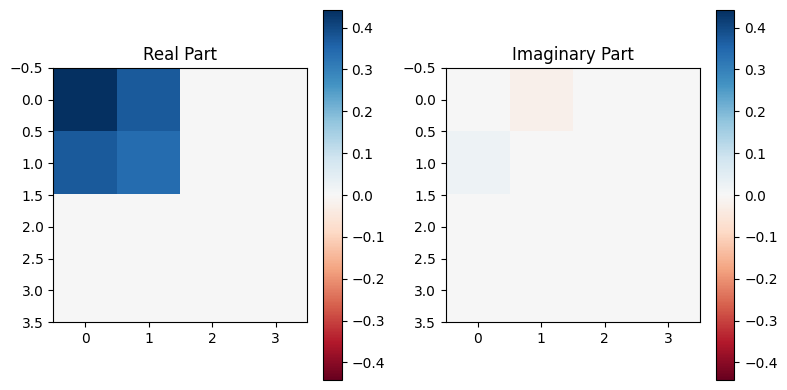

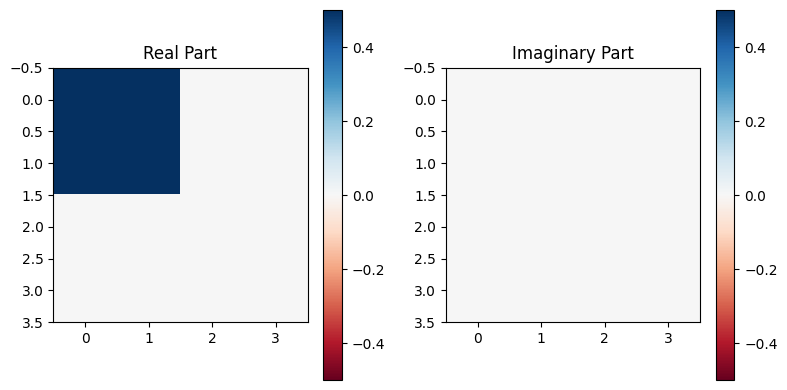

Opeators for VD


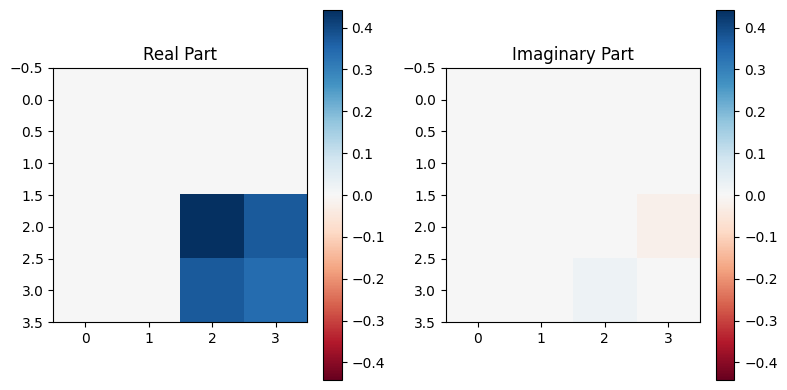

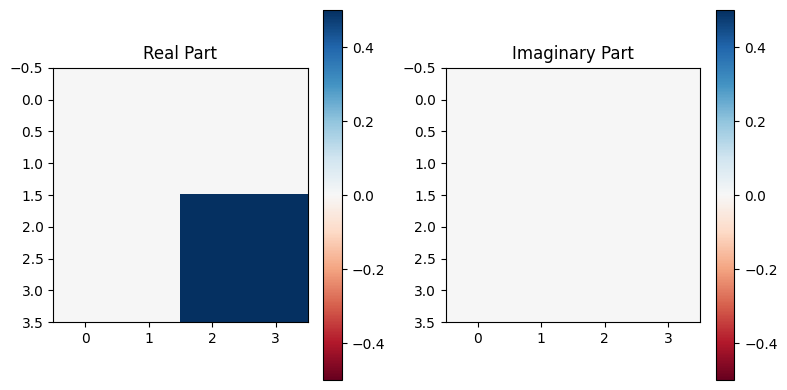

Opeators for VL


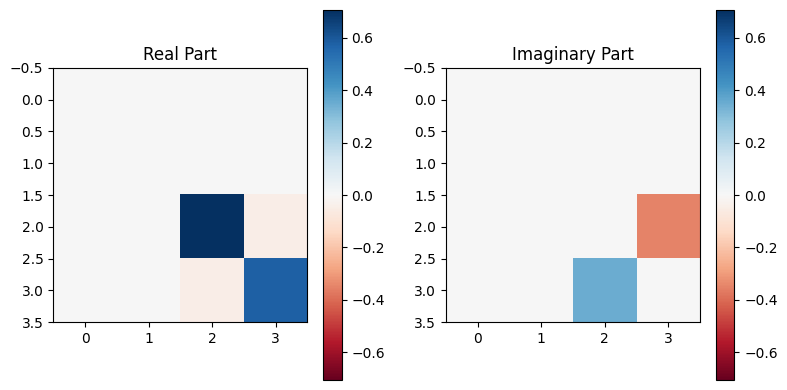

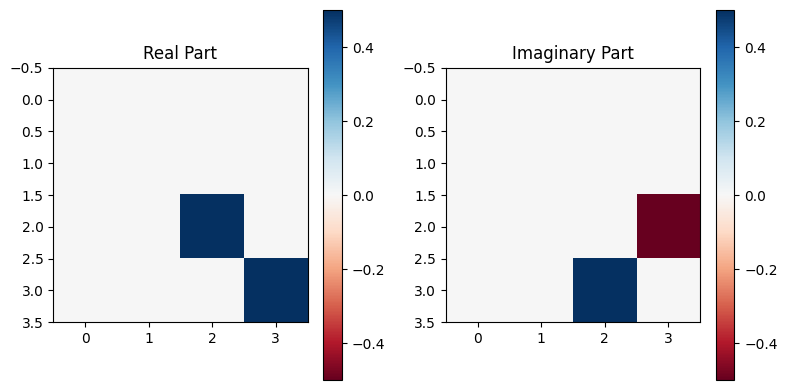

Opeators for HL


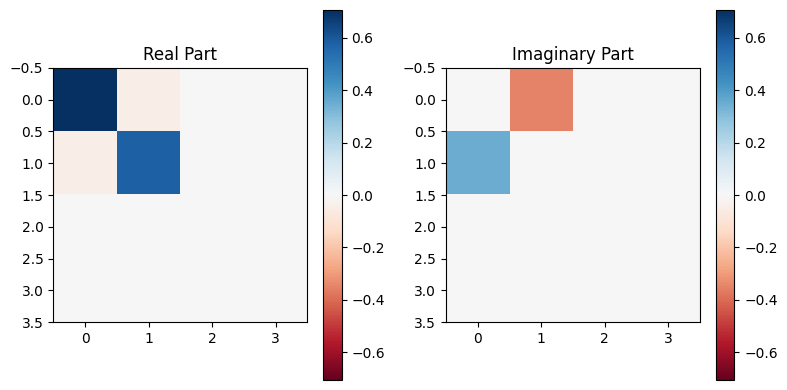

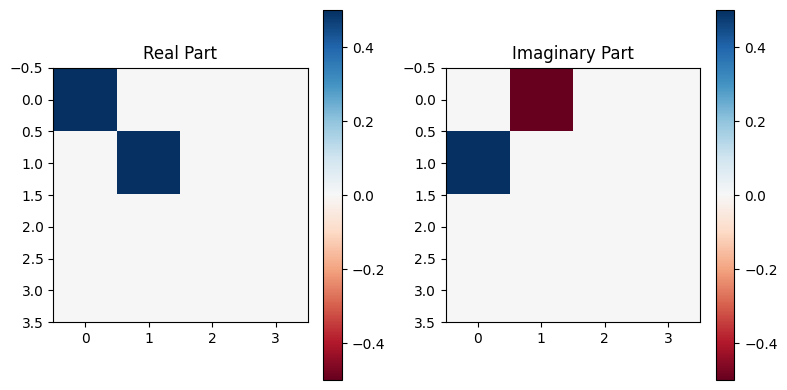

Opeators for RL


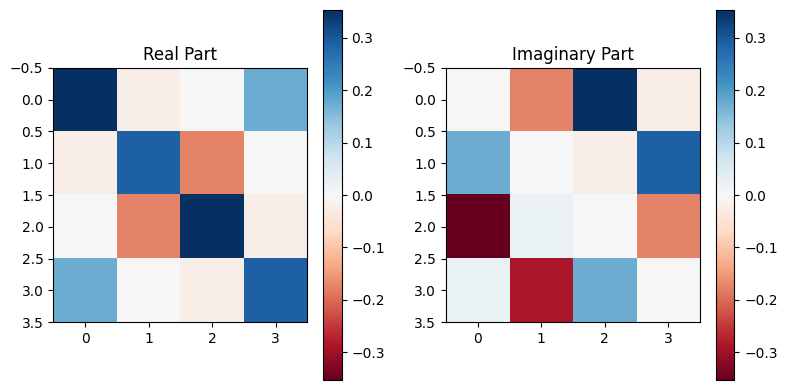

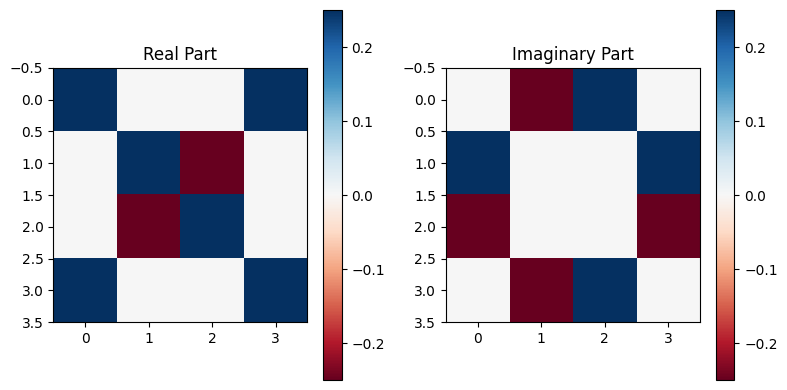

In [13]:
# Benchmark data issue/variability
benchmark_rations = benchmark_coinc_counts[0]/benchmark_coinc_counts[1]
print(f'Benchmark data ratio no lense/lense: {benchmark_rations}')
print(f'Benchmark coincs: \n{benchmark_coinc_counts}')
print(f'Problematic measurement is RH.')


# QDT data issue/variability

print(f'QDT coincs: \n{QDT_conts}')

print(f'Problematic is D state with R meaurement: {QDT_conts[14]}')
print(f'and L state with R measurement: {QDT_conts[-6]}')

temp_rho = sf.generate_random_Hilbert_Schmidt_mixed_state(2)
povm = POVM.generate_Pauli_POVM(2)
for pv in povm:
    hist = pv.get_histogram(temp_rho)
    n_tot = hist[0] + hist[1]
    n_tot2 = hist[0] + hist[2]
    print(n_tot,n_tot2)

for i in range(len(coincidence_op_list)):
    print(f'Opeators for {coincidene_order_QST[i]}')
    vis.visualize_state(coincidence_op_list[i])
    vis.visualize_state(QST_op_order[i])